In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [8]:
class MLP():
    def __init__(self, label_corrupt=0.0):
        self.label_corrupt = label_corrupt
        
        self.x = tf.placeholder(tf.float32, [None, 784])


        self.n1_hidden = 100
        self.W1 = tf.Variable(tf.random_normal([784, self.n1_hidden]))
        self.b1 = tf.Variable(tf.random_normal([self.n1_hidden]))
        self.W2 = tf.Variable(tf.random_normal([self.n1_hidden, 10]))
        self.b2 = tf.Variable(tf.random_normal([10]))

        self.z = tf.nn.softmax(tf.matmul(self.x, self.W1) + self.b1)

        self.mask = tf.placeholder(tf.float32, [None, self.n1_hidden])

        self.y = tf.nn.softmax(tf.matmul(self.z * self.mask, self.W2) + self.b2)

        self.y_ = tf.placeholder(tf.float32, [None, 10])

        self.mu = tf.placeholder(tf.float32)

        self.reg = (tf.reduce_sum(self.W1**2) + tf.reduce_sum(self.W2**2) + tf.reduce_sum(tf.abs(self.W1)) + tf.reduce_sum(tf.abs(self.W2)) )
        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.y_ * tf.log(self.y), reduction_indices=[1])) + self.mu * self.reg 

        self.train_step = tf.train.AdamOptimizer().minimize(self.cross_entropy)

        self.correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.y_,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
        
        
        self.sess = tf.Session()
        
        self._gen_data()
        
    def _gen_data(self):
        self.mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
        index = np.arange(0, self.mnist.train.labels.shape[0])[np.random.rand(self.mnist.train.labels.shape[0])<self.label_corrupt]
        corrupt_label = np.random.randint(0, 10, size=(index.shape[0]))
        
        self.mnist.train.labels[index, :] = 0
        self.mnist.train.labels[index, corrupt_label] = 1
        
    def train(self):
        self.sess.run(tf.global_variables_initializer())
        for i in range(10000):
            batch_xs, batch_ys = self.mnist.train.next_batch(128)
            self.sess.run(self.train_step, feed_dict={self.x: batch_xs, self.y_: batch_ys, self.mu:1e-6, self.mask: np.ones((128, self.n1_hidden)) })


            if i % 1000 == 0:
                print '\r%d ACC:' % i, 
                print 'train', self.sess.run(self.accuracy, feed_dict={self.x: self.mnist.train.images, self.y_: self.mnist.train.labels, self.mask: np.ones((self.mnist.train.images.shape[0], self.n1_hidden) )}) ,
                print 'val', self.sess.run(self.accuracy, feed_dict={self.x: self.mnist.validation.images, self.y_: self.mnist.validation.labels, self.mask: np.ones((self.mnist.validation.images.shape[0], self.n1_hidden) )}) ,
                print 'test',  self.sess.run(self.accuracy, feed_dict={self.x: self.mnist.test.images, self.y_: self.mnist.test.labels, self.mask: np.ones((self.mnist.test.images.shape[0], self.n1_hidden) )}) ,

        print ''

In [16]:
m0 = MLP(0.0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [17]:
m0.train()

9000 ACC: train 0.941236 val 0.9288 test 0.9233 


In [36]:
def get_plot_data(m):
    x = []
    y = []

    for ri in np.linspace(0, 1, 10):
        mask = np.ones((m.mnist.train.images.shape[0], m.n1_hidden))
        ind = np.random.rand(mask.shape[1]) < ri
        mask[:, ind] = 0.0

        x.append(ri)
        yi = m.sess.run(m.accuracy, feed_dict={m.x: m.mnist.train.images, m.y_: m.mnist.train.labels, m.mask:  mask }) 
        y.append(yi)
    return x, y

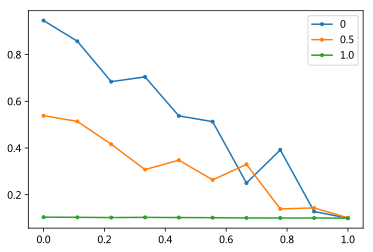

In [37]:
import matplotlib.pyplot as plt

for m in [m0, m1, m2]:
    x, y = get_plot_data(m)
    plt.plot(x, y, '.-')
    
plt.legend(['0', '0.5', '1.0'])

In [4]:
m1 = MLP(0.5)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
m1.train()

9000 ACC: train 0.5342 val 0.904 test 0.9008 


In [10]:
m1.sess.run(tf.argmax(m1.y,1), feed_dict={
        m1.x: m1.mnist.validation.images, 
        m1.mask: np.ones((m1.mnist.validation.images.shape[0], m1.n1_hidden) )
    })

array([5, 0, 4, ..., 2, 1, 2])

In [13]:
m1.mnist.validation.labels.argmax(1)

array([5, 0, 4, ..., 2, 1, 2])

In [15]:
m1.sess.run(m1.accuracy, feed_dict={
        m1.x: m1.mnist.train.images, 
        m1.y_: m1.mnist.train.labels, 
        m1.mask: np.ones((m1.mnist.train.images.shape[0], m1.n1_hidden) )
    })

0.53807271

In [6]:
m1.mnist.train.labels[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

In [7]:
m2 = MLP(1.0)
m2.train()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
9000 ACC: train 0.104945 val 0.099 test 0.0952 
